# Functions and imports

In [2]:
%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def get_users_pair(users):
    u1 = random.choice(users)
    u2 = random.choice(users)
    while u1 == u2:
        u2 = random.choice(users)
    return u1, u2

def save_conf(conf):
    with open(conf['output_dir']+"conf.json", "w") as f:
        conf2 = deepcopy(conf)
        conf2['period'] = str(conf2['period'])
        json.dump(conf2, f)
def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf        

def init_dir(path):
    if path is None:
        return
    if os.path.isdir(path):
        if os.listdir(path):
            ans = input("Remove previous content of "+path+"? (y/N) ")
            if ans == 'Y' or ans == 'y' or ans == 'o' or ans == 'O':
                shutil.rmtree(path)
    if not os.path.isdir(path):
        os.makedirs(path)

class Experiment:
    def __init__(self, conf):
        self.conf = conf
        
        # Initializing stuff
        if conf['do_monitor']:
            init_dir(conf['output_dir'])
        self.address_book = PeersView(conf)
        self.net = Network()
        self.users = [None] * conf['n_users']
        for i in range(conf['n_users']):
            self.users[i] = User(self.address_book, self.net, conf)
        
    def run(self):
        t_start = time.perf_counter()
        
        # Start greenlets
        for u in self.users:
            u.start()


        # Wait a bit for everyone to register to address_book
        gevent.sleep(self.conf['period'].total_seconds()/2)
        
        # Start file exchange
        self.users_pairs = set()
        self.files_info_r = []
        while len(self.users_pairs) < self.conf['n_file_exchanges']:
            u1, u2 = get_users_pair(self.users)
            # We don't want two users to exchange files twice among them
            if (u1, u2) in self.users_pairs:
                continue
            # Now try creating the route, else try again
            try:
                file_info = u2.init_file_receive(u1)
            except Exception as e:
                pass
            else:
                self.users_pairs.add((u1, u2))
                self.files_info_r.append(file_info)
                
                print("[{}] {} will send a file to {}.".format(
                    self.conf['experiment_name'], u1.name, u2.name))
                
        # Also fetch the sender's files_info
        self.files_info_s = [v  for u in self.users 
                           for _, v in u.sending_files.items()]
        self.n_file_exchanges = len(self.files_info_s)

        # The loop
        all_files_acknowledged = False
        while not all_files_acknowledged:
            all_files_acknowledged = all([
                finfo['f'].all_acknowledged() 
                for finfo in self.files_info_s])
            
            if all_files_acknowledged:
                break
            
            # Progression text
            completion = [None] * self.n_file_exchanges
            n_chunks = 0
            for i, finfo in enumerate(self.files_info_s):
                completion[i] = sum(finfo['f'].acked_chunks)
                n_chunks += finfo['f'].n_chunks
#                 print("[{}] File {} completed at {:.0%}.".format(
#                     self.conf['experiment_name'], finfo['f'].id, completion[i]))
            print("[{}] Files transfer at {:.0%} overall.".format(
                self.conf['experiment_name'], sum(completion) / n_chunks))
            
            # Sleep
            if not all_files_acknowledged:
                gevent.sleep(self.conf['period'].total_seconds())
        
        print("[{}] All files were acknowledged.".format(self.conf['experiment_name']))
        
        # Request for users to die
        for u in self.users:
            u.please_die()
        gevent.joinall(self.users)
        
        # Save config
        if self.conf['output_dir'] is not None:
            save_conf(self.conf)
            with open(self.conf['output_dir']+"files_info.bin", 'wb') as f:
                pickle.dump(self.files_info_s, f)

        print("[{}] Done in {:.0f}s.".format(
            self.conf['experiment_name'],
            time.perf_counter() - t_start))

# File sharing

Le temps d'échange des fichiers est proportionnel au nombre d'utilisateurs...

In [3]:
experiment_set = True

def run_experiment_varying_users(experiment_id, n_users):
    conf = config.default
    conf['n_users'] = n_users
    conf['n_rounds'] = 200
    conf['period'] = timedelta(seconds=10)
    conf['do_monitor'] = True
    conf['experiment_id'] = experiment_id
    conf['experiment_name'] = "experiment"+str(experiment_id)+"_"+str(n_users)+"users"
    conf['output_dir'] = 'data/'+experiment_set_name+'/'+conf['experiment_name']+'/'
    conf['send_strategy'] = 'random_connected'
    conf['n_file_exchanges'] = 10
    
    experiment = Experiment(conf)
    experiment.run()

def run_experiment(experiment_id):
    conf = config.default
    conf['n_users'] = 10
    conf['n_rounds'] = 200
    conf['period'] = timedelta(seconds=10)
    conf['do_monitor'] = True
    conf['experiment_id'] = experiment_id
    conf['experiment_name'] = "experiment"+str(experiment_id)
    conf['output_dir'] = 'data/'+experiment_set_name+'/'+conf['experiment_name']+'/'
    conf['send_strategy'] = 'random_connected'
    conf['n_file_exchanges'] = 10
    
    experiment = Experiment(conf)
    experiment.run()

experiment_set_name = "users_number"
#N_EXPERIMENTS = 100
# couple (experiment_id, n_users) such that n_users in [5, 10, ..., 25] 
# and 100 experiments per n_users
EXPERIMENTS_PER_N_USERS = 10
N_USERS_STEP = 5
N_USERS_BINS = 10
experiment_id_n_users = [(i, N_USERS_STEP * (i % N_USERS_BINS + 1)) \
     for i in range(N_USERS_BINS*EXPERIMENTS_PER_N_USERS)]

input('Ready?')
if os.path.isdir('data/'+experiment_set_name+'/'):
    shutil.rmtree('data/'+experiment_set_name+'/')
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    #p.map(run_experiment, range(1, N_EXPERIMENTS+1))
    p.starmap(run_experiment_varying_users, experiment_id_n_users)

Ready?
[experiment0_5users] Beatriz will send a file to Kandi.
[experiment0_5users] Sherie will send a file to Kandi.
[experiment0_5users] Many will send a file to Moira.
[experiment0_5users] Sherie will send a file to Beatriz.
[experiment21_10users] Stephany will send a file to Jean Panda.
[experiment0_5users] Many will send a file to Sherie.
[experiment21_10users] Broderick will send a file to Bronwyn.
[experiment0_5users] Sherie will send a file to Many.
[experiment0_5users] Kandi will send a file to Many.
[experiment21_10users] Dora will send a file to Stephany.
[experiment0_5users] Kandi will send a file to Sherie.
[experiment21_10users] Bronwyn will send a file to Jayne.
[experiment0_5users] Many will send a file to Beatriz.
[experiment0_5users] Moira will send a file to Sherie.
[experiment0_5users] Files transfer at 0% overall.
[experiment21_10users] Stephany will send a file to Elvera.
[experiment21_10users] Dora will send a file to Elinor.
[experiment21_10users] Elinor will se

User Delilah is done.
User Kandi is done.
User Julius is done.
User Lizzette is done.
User Lila is done.
User Vickey is done.
User Jay Z is done.
User Kaci is done.
User Rick is done.
User Beatriz is done.
User Vicki is done.
User Delaine is done.
User Kermit is done.
User Jayne is done.
User Isaura is done.
User Jillian is done.
[experiment8_45users] Bobbi will send a file to Buffy.
[experiment8_45users] Lyndsey will send a file to Garnett.
[experiment8_45users] Leigh will send a file to Vonnie.
[experiment8_45users] Luke will send a file to Gloria.
[experiment8_45users] Gloria will send a file to Bobbi.
User Maxwell is done.
[experiment8_45users] Sandie will send a file to Sherie.
[experiment8_45users] Lyndsey will send a file to Shawnda.
[experiment8_45users] Files transfer at 0% overall.
User Angelika is done.
User Lizzette is done.
User Lizzette is done.
User Lavette is done.
User Vonnie is done.
User Sandie is done.
User Norene is done.
[experiment14_25users] Done in 238s.
[exper

User Luke is done.
User Shawnda is done.
User Jayne is done.
User Magdalen is done.
User Demetra is done.
[experiment22_15users] Files transfer at 76% overall.
User Bronwyn is done.
User Many is done.
User Vickey is done.
User Sibyl is done.
User Janis is done.
User Kaci is done.
User Buffy is done.
User Sandie is done.
Done receiving file u1v1bj!
[experiment15_30users] Files transfer at 96% overall.
User Leigh is done.
User Leigh is done.
User Consuelo is done.
User Daniel is done.
User Jayne is done.
User Vonnie is done.
User Bobbi is done.
User Cordia is done.
User Bobbi is done.
[experiment1_10users] Files transfer at 94% overall.
User Garnett is done.
User Sherie is done.
User Sandie is done.
Done receiving file vhcgdp!
User Lyndsey is done.
User Herma is done.
User Luke is done.
User Maurita is done.
User Maurita is done.
User Buffy is done.
User Randolph is done.
User Nelly is done.
User Jay Z is done.
User Evelyne is done.
User Athena is done.
User Rick is done.
User Queen is d

[experiment2_15users] Files transfer at 17% overall.
[experiment23_20users] Files transfer at 1% overall.
[experiment16_35users] Files transfer at 4% overall.
Done receiving file atsivf!
[experiment9_50users] Files transfer at 94% overall.
Done receiving file ecalth!
Done receiving file eyocm3!
Done receiving file s5xajt!
[experiment2_15users] Files transfer at 29% overall.
[experiment23_20users] Files transfer at 5% overall.
[experiment16_35users] Files transfer at 15% overall.
[experiment9_50users] Files transfer at 95% overall.
[experiment9_50users] Files transfer at 96% overall.
[experiment23_20users] Files transfer at 8% overall.
[experiment16_35users] Files transfer at 32% overall.
[experiment2_15users] Files transfer at 63% overall.
[experiment9_50users] Files transfer at 96% overall.
[experiment23_20users] Files transfer at 14% overall.
[experiment16_35users] Files transfer at 46% overall.
[experiment2_15users] Files transfer at 74% overall.
Done receiving file oe3s8o!
[experim

[experiment3_20users] Demetra will send a file to Denver.
[experiment3_20users] Elinor will send a file to Denver.
[experiment3_20users] Brian will send a file to Elinor.
[experiment3_20users] Consuelo will send a file to Broderick.
[experiment3_20users] Mazie will send a file to Denver.
[experiment3_20users] Consuelo will send a file to Brian.
[experiment3_20users] Consuelo will send a file to Denver.
[experiment3_20users] Lila will send a file to Consuelo.
[experiment3_20users] Files transfer at 0% overall.
[experiment23_20users] Files transfer at 97% overall.
[experiment10_5users] Files transfer at 59% overall.
[experiment17_40users] Files transfer at 0% overall.
[experiment23_20users] Files transfer at 97% overall.
[experiment3_20users] Files transfer at 0% overall.
[experiment10_5users] Files transfer at 64% overall.
[experiment17_40users] Files transfer at 2% overall.
[experiment23_20users] Files transfer at 98% overall.
Done receiving file 0073ok!
[experiment3_20users] Files tra

[experiment3_20users] Files transfer at 100% overall.
[experiment23_20users] Files transfer at 99% overall.
Done receiving file wieemw!
[experiment18_45users] Files transfer at 1% overall.
Done receiving file 8lgtsy!
[experiment3_20users] All files were acknowledged.
User Evelyne is done.
User Consuelo is done.
User Lorine is done.
User Cordia is done.
User Demetra is done.
User Broderick is done.
User Denver is done.
User Vicki is done.
[experiment23_20users] Files transfer at 99% overall.
[experiment11_10users] Files transfer at 61% overall.
User Magdalen is done.
User Consuelo is done.
User Elinor is done.
User Yuriko is done.
User Brian is done.
User Lucy is done.
User Herma is done.
User Denver is done.
User Adaline is done.
User Lila is done.
User Lucy is done.
[experiment18_45users] Files transfer at 3% overall.
User Mazie is done.
[experiment3_20users] Done in 295s.
[experiment23_20users] Files transfer at 99% overall.
[experiment4_25users] Reita will send a file to Twila.
[exp

[experiment19_50users] Angelika will send a file to Moira.
[experiment19_50users] Janis will send a file to Moira.
[experiment19_50users] Jayne will send a file to Morgan.
[experiment19_50users] Luke will send a file to Mazie.
[experiment19_50users] Lucy will send a file to Kermit.
[experiment19_50users] Reita will send a file to Mi.
[experiment19_50users] Reita will send a file to Jillian.
[experiment19_50users] Kermit will send a file to Gilda.
[experiment19_50users] Angelika will send a file to Kermit.
[experiment19_50users] Files transfer at 0% overall.
[experiment24_25users] Files transfer at 3% overall.
[experiment4_25users] Files transfer at 94% overall.
[experiment12_15users] Files transfer at 0% overall.
[experiment19_50users] Files transfer at 0% overall.
Done receiving file oxk052!
Done receiving file fxobmk!
[experiment24_25users] Files transfer at 5% overall.
[experiment4_25users] Files transfer at 95% overall.
[experiment12_15users] Files transfer at 0% overall.
[experime

User Beatriz is done.
User Betty is done.
[experiment19_50users] Done in 292s.
[experiment12_15users] Files transfer at 94% overall.
[experiment20_5users] January will send a file to Herma.
[experiment20_5users] Herma will send a file to Renna.
[experiment20_5users] January will send a file to Yuriko.
[experiment20_5users] Yuriko will send a file to Demetra.
[experiment20_5users] Renna will send a file to Demetra.
[experiment20_5users] January will send a file to Renna.
[experiment20_5users] Demetra will send a file to January.
[experiment20_5users] Herma will send a file to Demetra.
[experiment20_5users] Renna will send a file to Herma.
[experiment20_5users] Demetra will send a file to Renna.
[experiment20_5users] Files transfer at 0% overall.
[experiment24_25users] Files transfer at 99% overall.
[experiment5_30users] Files transfer at 86% overall.
[experiment12_15users] Files transfer at 94% overall.
Done receiving file 7ono8c!
[experiment24_25users] Files transfer at 99% overall.
[e

[experiment24_25users] Files transfer at 99% overall.
[experiment6_35users] Files transfer at 0% overall.
[experiment13_20users] Files transfer at 81% overall.
[experiment24_25users] Files transfer at 99% overall.
[experiment20_5users] Files transfer at 97% overall.
[experiment6_35users] Files transfer at 0% overall.
Done receiving file ea71ig!
[experiment24_25users] Files transfer at 99% overall.
[experiment13_20users] Files transfer at 86% overall.
[experiment20_5users] Files transfer at 98% overall.
[experiment6_35users] Files transfer at 0% overall.
[experiment24_25users] Files transfer at 99% overall.
[experiment13_20users] Files transfer at 89% overall.
[experiment24_25users] Files transfer at 99% overall.
[experiment20_5users] Files transfer at 98% overall.
[experiment6_35users] Files transfer at 2% overall.
Done receiving file 4oa58l!
[experiment24_25users] Files transfer at 99% overall.
Done receiving file uw3k11!
[experiment13_20users] Files transfer at 94% overall.
[experime

[experiment28_45users] Files transfer at 77% overall.
[experiment25_30users] Files transfer at 37% overall.
[experiment6_35users] Files transfer at 95% overall.
Done receiving file hid01c!
Done receiving file ru7yqq!
[experiment35_30users] Files transfer at 53% overall.
[experiment28_45users] Files transfer at 83% overall.
[experiment25_30users] Files transfer at 64% overall.
[experiment6_35users] Files transfer at 95% overall.
Done receiving file e5r5d1!
Done receiving file 24qaw9!
[experiment28_45users] Files transfer at 87% overall.
[experiment35_30users] Files transfer at 68% overall.
[experiment6_35users] Files transfer at 97% overall.
[experiment25_30users] Files transfer at 79% overall.
[experiment28_45users] Files transfer at 90% overall.
[experiment35_30users] Files transfer at 75% overall.
[experiment6_35users] Files transfer at 98% overall.
[experiment25_30users] Files transfer at 85% overall.
Done receiving file lfvh24!
[experiment28_45users] Files transfer at 90% overall.


[experiment36_35users] Queen will send a file to Elinor.
[experiment36_35users] Brian will send a file to Karlene.
[experiment36_35users] Elvera will send a file to Livia.
[experiment36_35users] Nadia will send a file to Denver.
[experiment36_35users] Jean Panda will send a file to Queen.
[experiment36_35users] Files transfer at 0% overall.
[experiment28_45users] Files transfer at 98% overall.
[experiment26_35users] Files transfer at 13% overall.
[experiment42_15users] Files transfer at 74% overall.
[experiment36_35users] Files transfer at 0% overall.
[experiment28_45users] Files transfer at 99% overall.
[experiment26_35users] Files transfer at 16% overall.
Done receiving file 1v6uvg!
Done receiving file ezpnod!
[experiment42_15users] Files transfer at 81% overall.
[experiment28_45users] All files were acknowledged.
User Kaci is done.
User Lila is done.
User Kaci is done.
User Lavette is done.
User Consuelo is done.
User Shawnda is done.
User Kermit is done.
User Demetra is done.
User 

[experiment27_40users] Betty will send a file to Julius.
[experiment27_40users] Sandie will send a file to Yuriko.
Done receiving file y1gdn2!
[experiment27_40users] Athena will send a file to Gilda.
[experiment43_20users] Files transfer at 0% overall.
[experiment27_40users] Maurita will send a file to Julius.
[experiment27_40users] Betty will send a file to Gloria.
[experiment27_40users] Julius will send a file to Sandie.
[experiment27_40users] Rick will send a file to Kandi.
[experiment27_40users] Files transfer at 0% overall.
Done receiving file dt0bpi!
Done receiving file 9wbuve!
Done receiving file jbj6bd!
[experiment29_50users] Files transfer at 92% overall.
[experiment36_35users] Files transfer at 99% overall.
[experiment27_40users] Files transfer at 0% overall.
[experiment43_20users] Files transfer at 0% overall.
[experiment29_50users] Files transfer at 93% overall.
[experiment36_35users] Files transfer at 99% overall.
Done receiving file tmo5cy!
[experiment27_40users] Files tr

[experiment37_40users] Files transfer at 95% overall.
Done receiving file fdl9gt!
[experiment43_20users] Files transfer at 99% overall.
Done receiving file ah41tt!
[experiment27_40users] Files transfer at 97% overall.
Done receiving file fmhosk!
[experiment37_40users] Files transfer at 97% overall.
[experiment43_20users] Files transfer at 100% overall.
[experiment30_5users] Files transfer at 90% overall.
Done receiving file pfkelg!
[experiment27_40users] Files transfer at 98% overall.
Done receiving file 64fiok!
Done receiving file cynkug!
[experiment37_40users] Files transfer at 97% overall.
[experiment43_20users] Files transfer at 100% overall.
[experiment27_40users] Files transfer at 98% overall.
Done receiving file as7uaa!
[experiment30_5users] Files transfer at 95% overall.
Done receiving file l9os2f!
[experiment37_40users] Files transfer at 98% overall.
[experiment43_20users] All files were acknowledged.
User Temika is done.
User Shane is done.
User Broderick is done.
User Karlen

User Herma is done.
[experiment31_10users] Files transfer at 14% overall.
[experiment27_40users] Files transfer at 98% overall.
User Athena is done.
User Moira is done.
User Athena is done.
User Nadia is done.
User Nelly is done.
User Elinor is done.
User Jessica is done.
User Cordia is done.
User Morty is done.
User Luke is done.
User Bobbi is done.
User Charissa is done.
User Norene is done.
User Isaura is done.
User Bobbi is done.
User Livia is done.
User Morty is done.
User Bronwyn is done.
User Annabel is done.
User Kandi is done.
User Buffy is done.
User Patty is done.
User Tim is done.
User Mazie is done.
[experiment44_25users] Done in 197s.
[experiment38_45users] Files transfer at 88% overall.
[experiment45_30users] Moira will send a file to Bennie.
[experiment45_30users] Broderick will send a file to Barry.
[experiment45_30users] Magaly will send a file to Athena.
[experiment45_30users] Benjamin will send a file to Bennie.
[experiment45_30users] Kaylee will send a file to Jani

[experiment39_50users] Elvera will send a file to Cristy.
[experiment39_50users] Elinor will send a file to Vonnie.
[experiment39_50users] Magdalen will send a file to Charissa.
[experiment39_50users] Janis will send a file to Elinor.
[experiment39_50users] Georgene will send a file to Broderick.
[experiment39_50users] Elinor will send a file to Delaine.
[experiment39_50users] Demetra will send a file to Rick.
[experiment39_50users] Vicki will send a file to Gloria.
[experiment39_50users] Livia will send a file to Georgene.
[experiment39_50users] Twila will send a file to Consuelo.
[experiment39_50users] Files transfer at 0% overall.
[experiment45_30users] Files transfer at 100% overall.
Done receiving file uam0l1!
[experiment31_10users] All files were acknowledged.
User Patty is done.
User Brande is done.
User Kaci is done.
User Bennie is done.
User Bennie is done.
User Daisy is done.
User Daniel is done.
User Many is done.
User Brande is done.
User Sherie is done.
[experiment31_10use

[build route] No more available nodes: early abort.
[build route] No more available nodes: early abort.
[experiment50_5users] Benjamin will send a file to Tim.
[experiment50_5users] Files transfer at 0% overall.
Done receiving file p0jy62!
[experiment46_35users] Files transfer at 45% overall.
[experiment32_15users] Files transfer at 83% overall.
Done receiving file 6cd2b9!
[experiment39_50users] Files transfer at 90% overall.
[experiment50_5users] Files transfer at 0% overall.
[experiment46_35users] Files transfer at 64% overall.
Done receiving file wud0lf!
[experiment32_15users] Files transfer at 86% overall.
Done receiving file 7cwubc!
[experiment39_50users] Files transfer at 93% overall.
Done receiving file radvaz!
Done receiving file 2439p2!
Done receiving file 5rpbwc!
Done receiving file c4umr8!
[experiment46_35users] Files transfer at 77% overall.
Done receiving file cr0nd3!
Done receiving file mlz6km!
[experiment50_5users] Files transfer at 0% overall.
[experiment32_15users] Fil

User Morgan is done.
User Many is done.
User Evelyne is done.
User Brian is done.
User Magdalen is done.
User Charissa is done.
User Twila is done.
User Elinor is done.
User Rick is done.
User Bronwyn is done.
User Yuriko is done.
User Consuelo is done.
User Jayne is done.
User Elvera is done.
User Livia is done.
User Gloria is done.
User Delaine is done.
User Twila is done.
User January is done.
User Garnett is done.
User Newton is done.
User Cristy is done.
User Vicki is done.
User Vicki is done.
User Vonnie is done.
[experiment39_50users] Done in 416s.
[experiment47_40users] Files transfer at 26% overall.
User Tim is done.
User Lorine is done.
User Britany is done.
User Benjamin is done.
[experiment50_5users] Done in 252s.
[experiment33_20users] Files transfer at 52% overall.
[experiment40_5users] Gilbert will send a file to Norene.
[experiment40_5users] Adaline will send a file to Norene.
[experiment40_5users] Norene will send a file to Gilbert.
[experiment40_5users] Jean Panda wil

Done receiving file i0lmq1!
[experiment33_20users] Files transfer at 95% overall.
[experiment51_10users] Files transfer at 100% overall.
Done receiving file shjbh6!
[experiment48_45users] Files transfer at 1% overall.
[experiment33_20users] Files transfer at 96% overall.
[experiment40_5users] Files transfer at 99% overall.
[experiment51_10users] All files were acknowledged.
User Adaline is done.
User Adaline is done.
User Cristy is done.
User Yuriko is done.
User Newton is done.
User Twila is done.
User Adaline is done.
[experiment33_20users] Files transfer at 96% overall.
User Gilbert is done.
User Maurita is done.
[experiment48_45users] Files transfer at 2% overall.
User January is done.
[experiment51_10users] Done in 250s.
Done receiving file 14kbvz!
Done receiving file umgopm!
[experiment33_20users] Files transfer at 96% overall.
[experiment40_5users] Files transfer at 99% overall.
[experiment52_15users] Morgan will send a file to Lyndsey.
[experiment52_15users] Beatriz will send a

[experiment56_35users] Files transfer at 0% overall.
[experiment41_10users] Files transfer at 39% overall.
[experiment52_15users] Files transfer at 97% overall.
Done receiving file u4tjq0!
[experiment34_25users] Files transfer at 2% overall.
[experiment56_35users] Files transfer at 0% overall.
[experiment52_15users] Files transfer at 98% overall.
Done receiving file svb9ny!
Done receiving file muo430!
[experiment41_10users] Files transfer at 64% overall.
Done receiving file y676zc!
Done receiving file y75jb5!
[experiment56_35users] Files transfer at 1% overall.
[experiment34_25users] Files transfer at 6% overall.
[experiment52_15users] Files transfer at 99% overall.
Done receiving file n0fcj6!
[experiment41_10users] Files transfer at 81% overall.
[experiment56_35users] Files transfer at 1% overall.
[experiment34_25users] Files transfer at 10% overall.
Done receiving file snvxjn!
[experiment52_15users] Files transfer at 100% overall.
[experiment41_10users] Files transfer at 89% overall.

[experiment63_20users] Files transfer at 18% overall.
[experiment53_20users] Files transfer at 92% overall.
[experiment56_35users] Files transfer at 100% overall.
Done receiving file 5xnnl2!
[experiment63_20users] Files transfer at 33% overall.
[experiment70_5users] Files transfer at 0% overall.
[experiment53_20users] Files transfer at 94% overall.
Done receiving file wxa61g!
[experiment56_35users] Files transfer at 100% overall.
[experiment63_20users] Files transfer at 50% overall.
[experiment70_5users] Files transfer at 8% overall.
Done receiving file u557he!
[experiment53_20users] Files transfer at 96% overall.
[experiment56_35users] All files were acknowledged.
Done receiving file xq2li5!
Done receiving file faw5a1!
User Randolph is done.
User Otha is done.
User Norene is done.
User Cristy is done.
User Consuelo is done.
User Nelly is done.
User Lavette is done.
User Lavette is done.
User Denver is done.
User Patty is done.
[experiment63_20users] Files transfer at 73% overall.
User

Done receiving file le531q!
Done receiving file dwdgtt!
[experiment53_20users] Files transfer at 99% overall.
[experiment71_10users] Files transfer at 1% overall.
[experiment57_40users] Files transfer at 100% overall.
[experiment64_25users] Files transfer at 16% overall.
[experiment53_20users] Files transfer at 99% overall.
Done receiving file yazxpt!
[experiment57_40users] Files transfer at 100% overall.
[experiment71_10users] Files transfer at 3% overall.
Done receiving file ejjdw2!
[experiment53_20users] Files transfer at 99% overall.
[experiment64_25users] Files transfer at 42% overall.
[experiment57_40users] All files were acknowledged.
User Kermit is done.
User Cordia is done.
User Buffy is done.
[experiment53_20users] Files transfer at 99% overall.
User Livia is done.
User Twila is done.
User Britany is done.
User Britany is done.
User Kaylee is done.
User Lavette is done.
User Lyndsey is done.
User Rick is done.
User Kandi is done.
User Tim is done.
User Delilah is done.
User L

[experiment65_30users] Files transfer at 9% overall.
Done receiving file ed44y7!
Done receiving file mpmm0q!
[experiment54_25users] Files transfer at 15% overall.
[experiment71_10users] Files transfer at 100% overall.
Done receiving file humjtd!
[experiment58_45users] Files transfer at 99% overall.
[experiment65_30users] Files transfer at 22% overall.
Done receiving file 0k05xb!
[experiment54_25users] Files transfer at 31% overall.
[experiment71_10users] All files were acknowledged.
[experiment58_45users] Files transfer at 100% overall.
User Otha is done.
User Consuelo is done.
User Bronwyn is done.
User Morty is done.
User Newton is done.
User Bennie is done.
User Reita is done.
User Bobbi is done.
User Yuriko is done.
User Nadia is done.
[experiment71_10users] Done in 284s.
Done receiving file iijqfe!
[experiment54_25users] Files transfer at 47% overall.
[experiment65_30users] Files transfer at 46% overall.
[experiment72_15users] Delaine will send a file to Tim.
[experiment72_15users

User Delilah is done.
User Newton is done.
User Cristy is done.
User Jean Panda is done.
User Kaylee is done.
User Adaline is done.
User Angelika is done.
User Athena is done.
[experiment59_50users] Files transfer at 4% overall.
Done receiving file 1vm6te!
User Bobbi is done.
User Broderick is done.
User Jayne is done.
User Consuelo is done.
User Nadia is done.
User Luke is done.
User Morty is done.
User Kandi is done.
User Patty is done.
User Garnett is done.
User Betty is done.
User Mi is done.
[experiment66_35users] Files transfer at 1% overall.
User Lizzette is done.
User Buffy is done.
User Patty is done.
[experiment72_15users] Files transfer at 92% overall.
Done receiving file m4ix8d!
Done receiving file uzqfab!
User Gloria is done.
User Benjamin is done.
[experiment54_25users] Done in 311s.
[experiment59_50users] Files transfer at 9% overall.
[experiment66_35users] Files transfer at 2% overall.
Done receiving file gn0qp8!
Done receiving file zrdkjm!
[experiment55_30users] Otha w

[experiment73_20users] Files transfer at 23% overall.
[experiment66_35users] Files transfer at 99% overall.
[experiment55_30users] Files transfer at 96% overall.
[experiment60_5users] Files transfer at 7% overall.
Done receiving file afy6nf!
[experiment66_35users] Files transfer at 100% overall.
[experiment73_20users] Files transfer at 47% overall.
Done receiving file npq2ni!
[experiment55_30users] Files transfer at 97% overall.
[experiment60_5users] Files transfer at 12% overall.
Done receiving file g6ecx7!
[experiment66_35users] All files were acknowledged.
User Many is done.
[experiment73_20users] Files transfer at 64% overall.
User Consuelo is done.
User Gloria is done.
User Patty is done.
User Julianna is done.
[experiment55_30users] Files transfer at 99% overall.
User Beatriz is done.
User Benjamin is done.
User Isaura is done.
User Angelika is done.
User Gilda is done.
User Morty is done.
User Annelle is done.
User Lizzette is done.
User Lizzette is done.
User Garnett is done.
U

[experiment77_40users] Files transfer at 74% overall.
[experiment60_5users] Files transfer at 100% overall.
[experiment67_40users] Files transfer at 94% overall.
[experiment74_25users] Files transfer at 0% overall.
Done receiving file 1g7rsy!
[experiment77_40users] Files transfer at 78% overall.
Done receiving file bksg3c!
[experiment60_5users] All files were acknowledged.
[experiment67_40users] Files transfer at 96% overall.
[experiment74_25users] Files transfer at 0% overall.
[experiment77_40users] Files transfer at 81% overall.
User Lila is done.
User Daisy is done.
User Maxwell is done.
User Charissa is done.
User Magaly is done.
[experiment60_5users] Done in 297s.
Done receiving file 7wrj8r!
[experiment67_40users] Files transfer at 98% overall.
[experiment61_10users] Rick will send a file to Sherie.
[experiment61_10users] Rick will send a file to Leigh.
[experiment61_10users] Sherie will send a file to Jessica.
[experiment61_10users] Jean Panda will send a file to Jessica.
[experi

User Janis is done.
User Norene is done.
User Elinor is done.
User Brande is done.
User Jessica is done.
User Magdalen is done.
User Sibyl is done.
User Lorine is done.
User Annabel is done.
[experiment74_25users] Done in 264s.
Done receiving file gibg6h!
[experiment61_10users] Files transfer at 98% overall.
[experiment78_45users] Files transfer at 10% overall.
[experiment75_30users] Denver will send a file to Tim.
[experiment75_30users] Georgene will send a file to Tim.
[experiment75_30users] Maxwell will send a file to January.
[experiment75_30users] Gloria will send a file to Jean Panda.
Done receiving file xx6bja!
[experiment75_30users] Gloria will send a file to Lizzette.
[experiment75_30users] Otha will send a file to Jean Panda.
[experiment75_30users] Garnett will send a file to Magdalen.
[experiment75_30users] Nadia will send a file to Morgan.
[experiment75_30users] Elvera will send a file to Sibyl.
[experiment75_30users] Jay Z will send a file to Denver.
[experiment75_30users]

[experiment69_50users] Nadia will send a file to Evelyne.
[experiment69_50users] Morgan will send a file to Many.
[experiment62_15users] Files transfer at 33% overall.
[experiment69_50users] Rick will send a file to Herma.
[experiment69_50users] Delilah will send a file to Elinor.
[experiment69_50users] Rick will send a file to Consuelo.
[experiment69_50users] Delilah will send a file to Renna.
[experiment69_50users] Bennie will send a file to Lila.
[experiment69_50users] Jack will send a file to Lavette.
[experiment69_50users] Evelyne will send a file to Tim.
[experiment69_50users] Files transfer at 0% overall.
[experiment79_50users] Files transfer at 0% overall.
[experiment75_30users] Files transfer at 99% overall.
Done receiving file a7fstp!
[experiment69_50users] Files transfer at 0% overall.
[experiment62_15users] Files transfer at 55% overall.
[experiment79_50users] Files transfer at 1% overall.
Done receiving file 0z8mta!
[experiment75_30users] Files transfer at 99% overall.
Don

Done receiving file cxctqo!
[experiment69_50users] All files were acknowledged.
User Lucy is done.
User Jessica is done.
User Jay Z is done.
User Kaylee is done.
User Beatriz is done.
User Lila is done.
User Herma is done.
User Morgan is done.
User Renna is done.
User Lizzette is done.
User Delilah is done.
User Jay Z is done.
User Consuelo is done.
User Many is done.
User Bennie is done.
User Gilbert is done.
User Delilah is done.
User Daisy is done.
User Rick is done.
User Beatriz is done.
User Renna is done.
User Evelyne is done.
User Ann is done.
User Stephany is done.
User Renna is done.
User Maurita is done.
User Gilbert is done.
User Morgan is done.
User Shane is done.
User Cristy is done.
User Consuelo is done.
User Leigh is done.
User Consuelo is done.
User Janis is done.
User Bobbi is done.
User Shane is done.
User Lorine is done.
[experiment79_50users] Files transfer at 98% overall.
Done receiving file c1bsbw!
[experiment76_35users] Files transfer at 92% overall.
User Queen 

Done receiving file cnwb9x!
[experiment98_45users] Files transfer at 12% overall.
Done receiving file qn0i1d!
[experiment84_25users] Files transfer at 96% overall.
[experiment80_5users] Files transfer at 46% overall.
[experiment91_10users] Files transfer at 89% overall.
Done receiving file bwhoa9!
Done receiving file qfy03l!
Done receiving file hntj8p!
[experiment98_45users] Files transfer at 30% overall.
[experiment84_25users] Files transfer at 97% overall.
[experiment91_10users] Files transfer at 93% overall.
[experiment98_45users] Files transfer at 49% overall.
[experiment84_25users] Files transfer at 97% overall.
[experiment80_5users] Files transfer at 59% overall.
[experiment91_10users] Files transfer at 94% overall.
Done receiving file 698846!
[experiment84_25users] Files transfer at 98% overall.
Done receiving file 9hxnjv!
[experiment98_45users] Files transfer at 62% overall.
Done receiving file 8qax3g!
[experiment91_10users] Files transfer at 94% overall.
Done receiving file jr

User Luke is done.
[experiment91_10users] Done in 418s.
[experiment85_30users] Files transfer at 87% overall.
Done receiving file z7wsa3!
Done receiving file 5unobr!
Done receiving file 1moijz!
[experiment99_50users] Files transfer at 4% overall.
[experiment92_15users] Kaci will send a file to Lorine.
[experiment92_15users] Jean Panda will send a file to Kaci.
[experiment92_15users] Lorine will send a file to Luke.
[experiment92_15users] Morty will send a file to Luke.
[experiment92_15users] Cordia will send a file to Lorine.
[experiment92_15users] Bennie will send a file to Delaine.
[experiment92_15users] Lorine will send a file to Cordia.
[experiment92_15users] Morty will send a file to Annelle.
[experiment92_15users] Annelle will send a file to Cordia.
Done receiving file oaqd7f!
[experiment92_15users] Beatriz will send a file to Kaci.
[experiment92_15users] Files transfer at 0% overall.
Done receiving file i2afl5!
Done receiving file 6rlxo0!
[experiment80_5users] Files transfer at 

[experiment92_15users] Files transfer at 99% overall.
[experiment86_35users] Files transfer at 8% overall.
[experiment81_10users] Files transfer at 0% overall.
Done receiving file l7scp1!
Done receiving file jh4yvk!
[experiment92_15users] Files transfer at 100% overall.
[experiment86_35users] Files transfer at 16% overall.
[experiment81_10users] Files transfer at 2% overall.
[experiment92_15users] Files transfer at 100% overall.
[experiment86_35users] Files transfer at 37% overall.
Done receiving file e5pc8b!
[experiment81_10users] Files transfer at 5% overall.
Done receiving file mnqqun!
[experiment92_15users] All files were acknowledged.
User Many is done.
User Annelle is done.
User Morty is done.
User Reita is done.
User Mi is done.
User Delaine is done.
User Lorine is done.
User Beatriz is done.
User Kaci is done.
[experiment86_35users] Files transfer at 60% overall.
User Nelly is done.
User Cordia is done.
User Jean Panda is done.
User Bennie is done.
User Lorine is done.
User Luk

[experiment94_25users] Moira will send a file to Garnett.
[experiment94_25users] Karlene will send a file to Shane.
[experiment94_25users] Sherie will send a file to Moira.
[experiment94_25users] Betty will send a file to Adaline.
[experiment94_25users] Karlene will send a file to Vickey.
[experiment94_25users] Gilbert will send a file to Moira.
[experiment94_25users] Bobbi will send a file to Jean Panda.
[experiment94_25users] Kaci will send a file to Garnett.
[experiment94_25users] Files transfer at 0% overall.
[experiment87_40users] Files transfer at 56% overall.
[experiment82_15users] Files transfer at 0% overall.
[experiment94_25users] Files transfer at 0% overall.
[experiment87_40users] Files transfer at 72% overall.
[experiment82_15users] Files transfer at 1% overall.
[experiment94_25users] Files transfer at 0% overall.
[experiment87_40users] Files transfer at 80% overall.
Done receiving file m6mw91!
[experiment82_15users] Files transfer at 5% overall.
[experiment94_25users] Fil

[experiment95_30users] Denver will send a file to Herma.
[experiment95_30users] Bronwyn will send a file to Herma.
[experiment95_30users] Jayne will send a file to Kermit.
[experiment95_30users] Files transfer at 0% overall.
[experiment88_45users] Files transfer at 83% overall.
[experiment83_20users] Files transfer at 2% overall.
[experiment95_30users] Files transfer at 0% overall.
[experiment88_45users] Files transfer at 88% overall.
Done receiving file aj9c6b!
[experiment83_20users] Files transfer at 6% overall.
Done receiving file az9k06!
[experiment95_30users] Files transfer at 1% overall.
[experiment88_45users] Files transfer at 91% overall.
Done receiving file p09m01!
[experiment83_20users] Files transfer at 10% overall.
[experiment95_30users] Files transfer at 5% overall.
[experiment88_45users] Files transfer at 94% overall.
Done receiving file ubcgen!
Done receiving file f3egb0!
[experiment83_20users] Files transfer at 15% overall.
Done receiving file 98jldo!
[experiment88_45us

User Nadia is done.
User Maxwell is done.
User Brian is done.
User Stephany is done.
User Twila is done.
User Isaura is done.
User Kandi is done.
User Vicki is done.
User Reita is done.
User Cristy is done.
User Georgene is done.
User Sherie is done.
User Consuelo is done.
User Kermit is done.
User Hassie is done.
User Many is done.
User Barry is done.
User Sibyl is done.
User Angelika is done.
User Kermit is done.
User Barry is done.
User Sherie is done.
User Lorine is done.
User Kermit is done.
User Brande is done.
User Sibyl is done.
User Ann is done.
User Angelika is done.
User Karlene is done.
User Annabel is done.
User Benjamin is done.
User Nadia is done.
User Maxwell is done.
User Nelly is done.
User Cristy is done.
User Sibyl is done.
User Shane is done.
User Maurita is done.
User Gilbert is done.
User Lyndsey is done.
User Norene is done.
User January is done.
User Delaine is done.
User Renna is done.
User Cristina is done.
User Julius is done.
User Renna is done.
User Betty 

In [4]:
experiment_set_name = "random_file_size"

def run_experiments(experiment_id):
    conf = config.default
    conf['n_users'] = 20
    conf['n_rounds'] = 200
    conf['period'] = timedelta(seconds=10)
    conf['do_monitor'] = True
    conf['experiment_id'] = experiment_id
    conf['min_file_size']= 5120,  # kB
    conf['max_file_size']= 512000,  # kB']
    conf['experiment_name'] = "experiment"+str(experiment_id)
    conf['output_dir'] = 'data/'+experiment_set_name+'/'+conf['experiment_name']+'/'
    conf['send_strategy'] = 'random_connected'
    conf['n_file_exchanges'] = 10
    
    experiment = Experiment(conf)
    experiment.run()

N_EXPERIMENTS = 100
input('Ready?')
if os.path.isdir('data/'+experiment_set_name+'/'):
    shutil.rmtree('data/'+experiment_set_name+'/')
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    p.map(run_experiments, range(N_EXPERIMENTS))

Ready?
User Angelika is done.
User Jayne is done.
User Britany is done.
User Barry is done.
User Julianna is done.
User Brian is done.
User Brande is done.
User Gloria is done.
User Jessica is done.
User Lucy is done.
User Lizzette is done.
User Brande is done.
User Benjamin is done.
User Georgene is done.
User Leigh is done.
User Julianna is done.
User Beatriz is done.
User Kandi is done.
User Nadia is done.
User Betty is done.
User Morty is done.
User Newton is done.
User Bennie is done.
User Kaylee is done.
User Adaline is done.
User Kaci is done.
User Livia is done.
User Sandie is done.
User Garnett is done.
User Julius is done.
User Evelyne is done.
User Patty is done.
User Kaylee is done.
User Isaura is done.
User Brande is done.
User Kaylee is done.
User Livia is done.
User Kaylee is done.
User Queen is done.
User Daniel is done.
User Broderick is done.
User Daisy is done.
User Sibyl is done.
User Elinor is done.
User Cordia is done.
User Magdalen is done.
User Britany is done.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/gevent/greenlet.py", line 536, in run
    result = self._run(*self.args, **self.kwargs)
  File "/home/adrien/Cloud/These/p2p-private-cloud/code/notebooks/file_exchange/device.py", line 58, in _run
    while not self.online.wait(0.1):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/gevent/event.py", line 219, in wait
    return self._wait(timeout)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/gevent/greenlet.py", line 536, in run
    result = self._run(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.5/dist-packages/gevent/event.py", line 126, in _wait
    if self.ready():
  File "/usr/local/lib/python3.5/dist-packages/gevent/greenlet.py", line 536, in run
    result = self._run(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.5/dist-packages/gevent/greenlet.py", line 536, in run
    r

KeyboardInterrupt: 

In [2]:
experiment_set = False
conf = config.default
conf['n_users'] = 10
conf['n_rounds'] = 100
conf['period'] = timedelta(seconds=10)
conf['do_monitor'] = False
conf['experiment_name'] = "random_connected_1M_chunks_send_greenlets"
conf['output_dir'] = 'data/'+conf['experiment_name']+'/'
conf['send_strategy'] = 'random_connected'
conf['n_file_exchanges'] = 10
print(conf)


experiment = Experiment(conf)
experiment.run()

{'max_file_size': 102400, 'layer_threshold': 0.001, 'do_monitor': False, 'n_file_chunks': 10, 'period': datetime.timedelta(0, 10), 'n_rounds': 100, 'ack_size': 0, 'header_size': 100, 'bandwidth': 200, 'experiment_name': 'random_connected_1M_chunks_send_greenlets', 'output_dir': 'data/random_connected_1M_chunks_send_greenlets/', 'gossip_size': 20, 'n_users': 10, 'send_strategy': 'random_connected', 'min_file_size': 10240, 'chunk_max_size': 512, 'ping_time': 0.1, 'n_file_exchanges': 10, 'minimum_node_availability': 0, 'n_layers': 3}
[random_connected_1M_chunks_send_greenlets] Kaci will send a file to Evelyne.
[random_connected_1M_chunks_send_greenlets] Vonnie will send a file to Cristina.
[random_connected_1M_chunks_send_greenlets] Sandie will send a file to Kaci.
[random_connected_1M_chunks_send_greenlets] Cristina will send a file to Reita.
[random_connected_1M_chunks_send_greenlets] Evelyne will send a file to Vonnie.
[random_connected_1M_chunks_send_greenlets] Sandie will send a file

In [39]:
files_info = [v  for u in experiment.users for _, v in u.sending_files.items()]
[file_info['f'].shared_chunks for file_info in files_info]

[array([2, 1, 2, 1, 2, 3, 6, 1, 1, 1], dtype=uint64),
 array([4, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 2, 1, 1, 1, 1, 3, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 2, 1, 2, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 3, 1, 4, 1, 1, 2, 1, 2, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 3, 3, 5, 1], dtype=uint64),
 array([3, 1, 1, 1, 1, 3, 8, 1, 1, 1], dtype=uint64),
 array([2, 1, 2, 1, 1, 1, 2, 1, 1, 2], dtype=uint64)]

# Interpretation

In [3]:
def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

if experiment_set:
    data_dir = 'data/'+experiment_set_name+''/'+conf['experiment_name']+'/'
else:
    data_dir = "data/"+conf['experiment_name']+'/'
#data_dir="data/experiment_set/experiment_1/"
conf, files_info, devices_df, users_df = fetch_experiment_data(data_dir)

## Plot traffic

In [5]:
if experiment_set:
    plot_dir = "outputs/"+experiment_set_name+"/"+conf['experiment_name']+'/'
else:
    plot_dir = "outputs/"+conf['experiment_name']+'/'
print("Plot dir:", plot_dir)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

Plot dir: outputs/random_connected_1M_chunks_send_greenlets/


In [6]:
files_id = np.unique(devices_df['file_id'])
n_files = len(files_id)
#BINS = 4 *  devices_df['current_round'].max()
BINS = math.ceil(max(devices_df['t']))
x = np.linspace(0, math.ceil(max(devices_df['t'])), num=BINS)
#MAX_TIME = math.ceil(max(devices_df['t']))

y = np.zeros((n_files, len(x) - 1), dtype=np.float64)
for i, f_id in enumerate(files_id):
    df = devices_df[devices_df['file_id'] == f_id]
    for t in range(0, len(x) - 1):
        df2 = df[(df['t'] >= t) & (df['t'] < t+1)]
        #y[i, t] = df2['sent'].sum() + df2['forwarded'].sum()
        y[i, t] = df2['received'].sum() 

array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 11240.,     0.,     0.,     0., 11240.,
            0.,     0.,     0., 13488., 22480., 23604.,     0.,     0.,
            0.,  3372.,  6744.,  3372., 13488.,     0.,     0.,     0.,
            0.,     0.,     0., 26976.,  5620., 10116.,     0.,     0.,
            0.,  8992.,  4696.,     0.,     0.,     0., 12340., 12364.,
        11740.,     0.,  2248.,  2600.,  4100.,  1100.,  7868.,  8544.,
         2000.,     0.],
       [    0.,     0.,     0.,     0.,  3372.,     0.,  4496.,     0.,
        14612.,     0.,  2248.,  5620.,     0.,  8992.,     0.,     0.,
            0., 10116.,     0.,     0.,     0.,  5620.,     0.,     0.,
        13488.,  1124.,     0.,     0.,     0.,  3372.,   100.,  2348.,
            0.,  4496.,   300.,     0.,

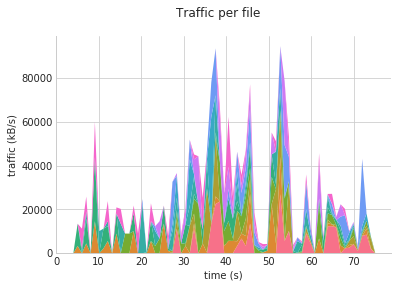

In [7]:
sns.set_style('whitegrid')
f, ax = plt.subplots()

ax.stackplot(x[1:], y, colors=sns.color_palette("husl", n_colors=n_files))

ax.set_xlabel('time (s)')
ax.set_ylabel('traffic (kB/s)')
ax.set_xlim(0, )
ax.set_ylim(0, )
plt.suptitle("Traffic per file")

sns.despine()
plt.savefig("outputs/"+conf['experiment_name']+'/traffic_per_file.svg')
plt.show()

### Messages' RTT

In [8]:
messages_id = np.unique(devices_df['mess_id'])
transfer_times = pd.DataFrame()
#transfer_times = np.zeros(len(messages_id), dtype=np.float64)

for i, m_id in enumerate(messages_id):
    times = [None] * 2
    for typ in [1, 2]:
        data = devices_df[(devices_df['mess_id'] == m_id) &
                          (devices_df['type'] == typ)]['t']
        
        if len(data) != 0:
            times[typ - 1] = max(data) - min(data)
            transfer_times = transfer_times.append(pd.Series({
                't': times[typ - 1], 
                'type': typ}), ignore_index=True)
            
    if times[0] is not None and times[1] is not None:
        transfer_times = transfer_times.append(pd.Series({
                't': sum(times), 
                'type': 3}), ignore_index=True)


def to_cdf(data):
    data_size = len(data)
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bins

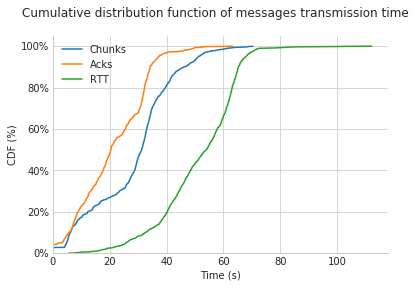

In [9]:
f, ax = plt.subplots()

# Plot the cdf
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 1]['t'])
ax.plot(bins[0:-1], cdf, label="Chunks")
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 2]['t'])
ax.plot(bins[0:-1], cdf, label="Acks")
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 3]['t'])
ax.plot(bins[0:-1], cdf, label="RTT")

ax.set_xlabel('Time (s)')
ax.set_xlim(0,)
ax.set_ylabel('CDF (%)')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0,)
ax.legend()
plt.suptitle('Cumulative distribution function of messages transmission time')


sns.despine()
plt.savefig('/messages_rtt_cdf.svg')
plt.show()

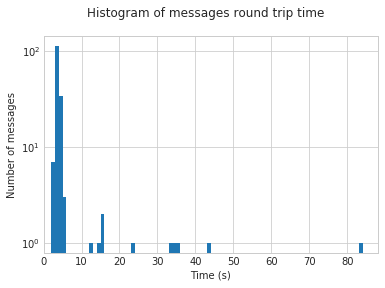

In [53]:
f, ax = plt.subplots()

ax.hist(transfer_times, bins=range(1, math.ceil(max(transfer_times))+1))

ax.set_xlabel('Time (s)')
ax.set_xlim(0,)
ax.set_ylabel('Number of messages')
ax.set_yscale('log')
plt.suptitle('Histogram of messages round trip time')

plt.savefig("outputs/"+conf['experiment_name']+'/messages_rtt_hist.svg')
plt.show()

### File reception time

In [78]:
messages_id.shape

(148,)

In [10]:
files_id = np.unique(devices_df['file_id'])

file_transfer_time = []
for f_id in files_id:
    beginning_time = devices_df[(devices_df['file_id'] == f_id) & (devices_df['type'] == 1) & (devices_df['sent'] != 0)]['t'].min()
    completion_time = devices_df[(devices_df['file_id'] == f_id) & (devices_df['type'] == 2) & (devices_df['received'] != 0)]['t'].max()
    
    file_transfer_time.append(completion_time - beginning_time)

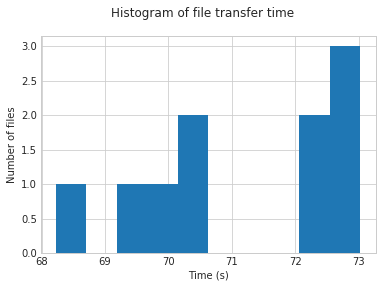

In [12]:
f, ax = plt.subplots()

ax.hist(file_transfer_time, bins=10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of files')
plt.suptitle('Histogram of file transfer time')

plt.savefig("outputs/"+conf['experiment_name']+'/files_time_hist.svg')
plt.show()